In [1]:
import os
import argparse
import cProfile
from io import StringIO
import pathlib

from pstats import SortKey, Stats
import numpy as np
import h5py
import matplotlib.pyplot as plt

from peripy import Model
from peripy.integrators import VelocityVerletCL
from peripy.utilities import write_array
from peripy.utilities import read_array as read_model

In [2]:
absolute_path = os.path.abspath('')

# The .msh file is a point cloud. '175beam3620.msh' contains 3620 particles.
mesh_file = absolute_path + '/175beam3620.msh'

write_path_model = absolute_path + '/175beam3620_model.h5'
write_path_solutions = absolute_path

## Define functions

In [3]:
def smooth_step_data(
        first_step, steps, start_value, final_value):
    """
    Apply a smooth 5th order polynomial as the displacement-time function for
    the simulation.

    :arg int start_time_step: The time step that the simulation starts from.
    :arg int steps: The number of steps in the simulation.
    :arg float start_value: The starting value of the displacement.
    :arg float final_value: The final value of the displacement.
    """
    alpha = np.zeros(first_step + steps)
    for current_time_step in range(first_step, first_step + steps):
        xi = (current_time_step - first_step) / steps
        alpha[current_time_step] = (start_value + (
            final_value - start_value) * xi**3 * (10 - 15 * xi + 6 * xi**2))
    return alpha

In [4]:
def is_tip(x):
    """
    Return a boolean list of tip types for each cartesian direction.

    Returns a boolean list, whose elements are a strings when the particle
    resides on a 'tip' to be measured for some displacement, velocity,
    acceleration, force or body_force in that cartesian direction. The value
    of the element of the list can be a string or an int, which is a flag for
    the tip type that the particle resides on. If a particle resides on more
    than one tip, then any of the list elements can be a tuple of tip types.

    :arg x: Particle coordinate array of size (3,).
    :type x: :class:`numpy.ndarray`

    :returns: A (3,) list of tip types.
    :rtype: List of (tuples of) None or string.
    """
    # Particle does not live on tip
    tip = [None, None, None]
    # Particle does live on a tip to me measured, in the centre of the beam
    if (x[0] > 0.0875 - 5.0e-3) and (x[0] < 0.0875 + 5.0e-3):
        if (x[2] > 0.025 - 5.0e-3) and (x[2] < 0.025 + 5.0e-3):
            # Measurements are made in the z direction
            tip[2] = 'deflection'
    # Measure the force applied at the boundaries, in the z direction
    if x[0] == 0.025 and x[2] == -0.01:
        tip[2] = 'force'
    if x[0] == 0.155 and x[2] == -0.01:
        tip[2] = 'force'
    # Measurement of the "crack mouth opening displacement" (CMOD)
    if x[0] == 0.125 and x[1] == 0.005 and x[2] == 0.005:
        tip[0] = 'CMOD_right'
    if x[0] == 0.055 and x[1] == 0.005 and x[2] == 0.005:
        tip[0] = 'CMOD_left'
    return tip

In [5]:
def is_density(x):
    """
    Return the density of the particle.

    :arg x: Particle coordinate array of size (3,).
    :type x: :class:`numpy.ndarray`

    :returns: density of concrete in [kg/m^3]
    :rtype: float
    """
    return 2346.0

In [6]:
def is_displacement_boundary(x):
    """
    Return a boolean list of displacement boundarys for each direction.

    Returns a (3,) boolean list, whose elements are:
        None where there is no boundary condition;
        -1 where the boundary is displacement loaded in negative direction;
        1 where the boundary is displacement loaded in positive direction;
        0 where the boundary is clamped;

    :arg x: Particle coordinate array of size (3,).
    :type x: :class:`numpy.ndarray`
    """
    # Particle does not live on a boundary
    bnd = [None, None, None]
    # Displacement controlled particles
    if x[0] == 0.085 and x[2] == 0.05:
        bnd[2] = -1
    if x[0] == 0.09 and x[2] == 0.05:
        bnd[2] = -1
    if x[0] == 0.095 and x[2] == 0.05:
        bnd[2] = -1
    # Clamped particles
    if (x[0] > 0.025 - 5e-3) and (x[0] < 0.025 + 5e-3) and (x[2] < -0.005):
        bnd[2] = 0
        bnd[1] = 0
    if (x[0] > 0.155 - 5e-3) and (x[0] < 0.155 + 5e-3) and (x[2] < -0.005):
        bnd[2] = 0
        bnd[1] = 0
    return bnd

## Constants

In [7]:
# Average one-dimensional grid separation between particles along an axis
dx = 5.0e-3
# Following convention, the horizon distance is taken as just over 3
# times the grid separation between particles
horizon = dx * np.pi
# Values of the particular trilinear constitutive model parameters
s_0 = 1.05e-4
s_1 = 6.90e-4
s_c = 5.56e-3
beta = 0.25
c = 2.32e18
c_1 = (beta * c * s_0 - c * s_0) / (s_1 - s_0)
c_2 = (- beta * c * s_0) / (s_c - s_1)
# Critical stretch for the trilinear constitutive model
critical_stretch = [np.float64(s_0), np.float64(s_1), np.float64(s_c)]
# Bond stiffness for the trilinear constitutive model
bond_stiffness = [np.float64(c), np.float64(c_1), np.float64(c_2)]
# Setting the dynamic relaxation damping constant to a critical value
# will help the system to converge to the quasi-static steady-state.
damping = 2.5e6
# Stable time step. Try increasing or decreasing it.
dt = 1.3e-6

## Boundary conditions

In [8]:
# The displacement boundary condition magnitudes increase with a 5th order
# polynomial so that the acceleration at the start and end of the
# simulation is zero. The displacement of 0.2mm is applied over
# 100,000 time-steps.
steps = 100000
applied_displacement = 2e-4
displacement_bc_array = smooth_step_data(0, steps, 0, applied_displacement)

## Solver (integrator)

In [9]:
integrator = VelocityVerletCL(dt=dt, damping=damping)

Device is AMD Radeon Pro 5500M Compute EngineGPU from AMD with a max of 24 compute units, 
a max of 256 work-items per work-group, 
a max work item dimensions of 3, 
a max work item sizes of [256, 256, 256],
and device local memory size is 65536 bytes. 


## Build model

In [10]:
model = Model(
    mesh_file, integrator=integrator, horizon=horizon,
    critical_stretch=critical_stretch, bond_stiffness=bond_stiffness,
    dimensions=3,
    volume_total=0.0004525,  # Total volume of the concrete beam
    is_density=is_density,
    is_displacement_boundary=is_displacement_boundary,
    is_tip=is_tip,
    write_path=write_path_model)

/Users/mark/Documents/Fellowship/2_Code/PeriPy/peripy/model.py:516: UserWarning: KeyError: 'tetra', setting Model.mesh_connectivity=False and in meshless mode: output `mesh' will not be connected, but it will be a point cloud.
  warnings.warn(


## Visualise the constitutive model

Text(0.5, 1.0, 'Trilinear constitutive model')

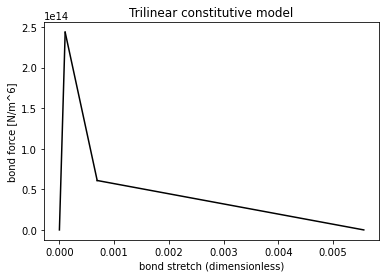

In [11]:
# Visualise the particular constitutive model being used
bond_stiffness, critical_stretch, plus_cs, *_ = model._set_damage_model(
    bond_stiffness, critical_stretch)
plt.plot(
    [0, critical_stretch[0]],
    [0, critical_stretch[0] * bond_stiffness[0] + plus_cs[0]],
    color='k')
plt.plot(
    [critical_stretch[0], critical_stretch[1]],
    [critical_stretch[0] * bond_stiffness[0],
        critical_stretch[1] * bond_stiffness[1] + plus_cs[1]],
    color='k')
plt.plot(
    [critical_stretch[1], critical_stretch[2]],
    [critical_stretch[1] * bond_stiffness[1] + plus_cs[1],
        critical_stretch[2] * bond_stiffness[2] + plus_cs[2]],
    color='k')
plt.xlabel('bond stretch (dimensionless)')
plt.ylabel('bond force [N/m^6]')
plt.title('Trilinear constitutive model')

## Run the simulation

In [12]:
# Run the simulation
# Use e.g. paraview to view the output .vtk files of simulate
(u, damage, connectivity, f, ud, data) = model.simulate(
    bond_stiffness=bond_stiffness,
    critical_stretch=critical_stretch,
    steps=steps,
    displacement_bc_magnitudes=displacement_bc_array,
    write_mesh=5000,  # write to mesh every 5000 time steps
    write_data=100)  # write to data every 100 time steps

Simulation Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:15<00:00, 1319.38steps/s]


## Write the numerical load-CMOD data to disk

In [13]:
force = np.array(data['force']['body_force']) / 1000
left_displacement = 1000. * np.array(data['CMOD_left']['displacement'])
right_displacement = 1000. * np.array(data['CMOD_right']['displacement'])
CMOD = np.subtract(right_displacement, left_displacement)

# Write load-CMOD data to disk
try:
    write_array(write_path_solutions + "/data.h5", "force", np.array(force))
    write_array(write_path_solutions + "/data.h5", "CMOD", np.array(CMOD))
except OSError:  # data.h5 already exists
    os.remove(write_path_solutions + "/data.h5")
    write_array(write_path_solutions + "/data.h5", "force", np.array(force))
    write_array(write_path_solutions + "/data.h5", "CMOD", np.array(CMOD))

## Plot the experimental load-CMOD data, verification data, and numerical output

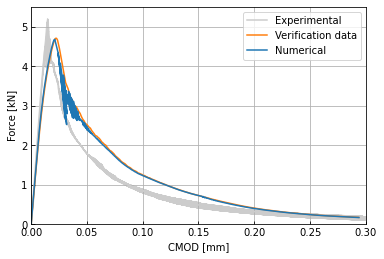

In [21]:
# Plot the experimental data
exp_data_path = absolute_path + "/experimental_data.h5"
exp_data = h5py.File(exp_data_path, 'r')
exp_load_CMOD = exp_data['load_CMOD']
exp_CMOD = exp_load_CMOD[0, 0:20000]
exp_load_mean = exp_load_CMOD[1, 0:20000]
exp_load_min = exp_load_CMOD[2, 0:20000]
exp_load_max = exp_load_CMOD[3, 0:20000]
plt.plot(exp_CMOD, exp_load_mean, color=(0.8, 0.8, 0.8),
         label='Experimental')
plt.fill_between(exp_CMOD, exp_load_min, exp_load_max,
                 color=(0.8, 0.8, 0.8))

# Plot the verification data
ver_data_path = absolute_path + "/verification_data.h5"
ver_data = h5py.File(ver_data_path, 'r')
ver_load_CMOD = ver_data['load_CMOD']
ver_load = ver_load_CMOD[0, 0:499] / 1000
ver_CMOD = ver_load_CMOD[1, 0:499]
plt.plot(ver_CMOD, ver_load, 'tab:orange', label='Verification data')

# Plot the numerical data
force = read_model(absolute_path + "/data.h5", "force")
CMOD = read_model(absolute_path + "/data.h5", "CMOD")
plt.plot(CMOD, -force, label='Numerical')
plt.xlabel('CMOD [mm]')
plt.ylabel('Force [kN]')
plt.grid(True)
axes = plt.gca()
axes.set_xlim([0, .3])
axes.set_ylim([0, 5.5])
axes.tick_params(direction='in')
plt.legend()